In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter

### Loading Data

In [2]:
train_data1 = np.loadtxt("TP/data/data_tp1_app.txt", delimiter=' ')
test_data1 = np.loadtxt("TP/data/data_tp1_dec.txt", delimiter=' ')

X_train1 = train_data1[:,1:]
y_train1 = train_data1[:,0]

X_test1 = test_data1[:,1:]
y_test1 = test_data1[:,0]

train_data2 = np.loadtxt("TP/data/data_tp2_app.txt", delimiter=' ')
test_data2 = np.loadtxt("TP/data/data_tp2_dec.txt", delimiter=' ')

X_train2 = train_data2[:,1:]
y_train2 = train_data2[:,0]

X_test2 = test_data2[:,1:]
y_test2 = test_data2[:,0]

train_data3 = np.loadtxt("TP/data/data_tp3_app.txt", delimiter=' ')
test_data3 = np.loadtxt("TP/data/data_tp3_dec.txt", delimiter=' ')

X_train3 = train_data3[:,1:]
y_train3 = train_data3[:,0]

X_test3 = test_data3[:,1:]
y_test3 = test_data3[:,0]

## Estimation de Gaussiennes

##### Euclidian and Majalanobis Distances

In [3]:
# Fonction pour calculer la distance euclidienne
def euclidean_distance(point, point2):
    return np.sqrt(np.sum((point - point2) ** 2))

# Fonction pour calculer la distance de Mahalanobis
def mahalanobis_distance(point, centroid, cov_matrix):
    diff = point - centroid
    inv_cov_matrix = np.linalg.inv(cov_matrix)  # Calculer l'inverse de la matrice de covariance
    return np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))

##### Classification

In [4]:
# Classifier les points basés sur la distance euclidienne et retourner les deux classes les plus proches
def classify_by_euclidean(test_data, centroids, unique_classes):
    top1_predictions = []
    top2_predictions = []
    for point in test_data[:, 1:3]:  # Ne considérer que les caractéristiques x1, x2
        distances = [euclidean_distance(point, centroid) for centroid in centroids]
        sorted_indices = np.argsort(distances)  # Indices des classes triées par distance croissante
        top1_predictions.append(unique_classes[sorted_indices[0]])  # Première classe (plus proche)
        top2_predictions.append(unique_classes[sorted_indices[1]])  # Deuxième classe (deuxième plus proche)
    return np.array(top1_predictions), np.array(top2_predictions)

# Classifier les points basés sur la distance de Mahalanobis et retourner les deux classes les plus proches
def classify_by_mahalanobis(test_data, centroids, var_cov, unique_classes):
    top1_predictions = []
    top2_predictions = []
    for point in test_data[:, 1:3]:  # Ne considérer que les caractéristiques x1, x2
        distances = [mahalanobis_distance(point, centroids[i], var_cov[i]) for i in range(len(centroids))]
        sorted_indices = np.argsort(distances)  # Indices des classes triées par distance croissante
        top1_predictions.append(unique_classes[sorted_indices[0]])  # Première classe (plus proche)
        top2_predictions.append(unique_classes[sorted_indices[1]])  # Deuxième classe (deuxième plus proche)
    return np.array(top1_predictions), np.array(top2_predictions)

##### Accuaracy and Plotting

In [5]:
# Comparer les prédictions avec les étiquettes réelles pour le Top1 et le Top2
def calculate_accuracy_top2(top1_predictions, top2_predictions, actual_labels):
    correct_top1 = np.sum(top1_predictions == actual_labels)
    correct_top2 = np.sum((top1_predictions == actual_labels) | (top2_predictions == actual_labels))  # Correct si c'est dans les deux premiers
    total = len(actual_labels)
    accuracy_top1 = correct_top1 / total * 100
    accuracy_top2 = correct_top2 / total * 100
    return accuracy_top1, accuracy_top2

# Créer une matrice de confusion
def Matrice_Confusion(actual_labels, predictions):
  classes = set(predictions)
  num_classes = len(classes)
  shape = (num_classes, num_classes)
  mat = np.zeros(shape)
  n = max(len(actual_labels),len(predictions))
  for i in range(num_classes):
    for j in range(num_classes):
      for k in range(n):
        if actual_labels[k]-1 == i:
          if predictions[k]-1 == j:
            mat[i][j] = mat[i][j] + 1
  return mat.astype(int)


# Fonction pour afficher les matrices de confusion côte à côte comme une heatmap
def plot_confusion_matrices(confusion_mtx1, confusion_mtx2, title1, title2, unique_classes):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # Création de sous-plots pour afficher les deux heatmaps côte à côte
    
    # Plot de la première matrice de confusion (Euclidienne)
    sns.heatmap(confusion_mtx1, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=unique_classes, yticklabels=unique_classes)
    ax[0].set_title(title1)
    ax[0].set_xlabel('Classe prédite')
    ax[0].set_ylabel('Classe réelle')
    
    # Plot de la deuxième matrice de confusion (Mahalanobis)
    sns.heatmap(confusion_mtx2, annot=True, fmt='d', cmap='Blues', ax=ax[1], xticklabels=unique_classes, yticklabels=unique_classes)
    ax[1].set_title(title2)
    ax[1].set_xlabel('Classe prédite')
    ax[1].set_ylabel('Classe réelle')
    
    plt.tight_layout()
    plt.show()

# Function to plot classification results side by side (Euclidean and Mahalanobis)
def plot_classifications_side_by_side(test_data, centroids, var_cov, unique_classes, 
                                      euclidean_top1_predictions, mahalanobis_top1_predictions):
    # Define color maps for background and points
    background_colors = ListedColormap(['red', 'orange', 'blue', 'green', 'purple', 'gray', 'yellow', 'cyan'])
    point_colors = ['red', 'orange', 'blue', 'green', 'purple']

    # Create a mesh grid for decision boundary plotting
    x_min, x_max = test_data[:, 1].min() - 1, test_data[:, 1].max() + 1
    y_min, y_max = test_data[:, 2].min() - 1, test_data[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Set up the figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # ---- Euclidean Plot ----

    # Prédire les classes sur le maillage
    Z_euclidean = np.array([classify_by_euclidean(np.array([[0, x, y]]), centroids, unique_classes)[0][0] 
                            for x, y in zip(xx.ravel(), yy.ravel())]).astype(int)

    print(np.unique(Z_euclidean))
    
    Z_euclidean = Z_euclidean.reshape(xx.shape)
    print(np.unique(Z_euclidean))
    
    # Plot the decision boundary for Euclidean
    ax1.contourf(xx, yy, Z_euclidean, alpha=0.3, colors=point_colors)

    np.savetxt("foo.csv", Z_euclidean, delimiter=",")
    
    # Plot test points for Euclidean
    for idx, class_label in enumerate(unique_classes):
        class_points = test_data[euclidean_top1_predictions == class_label]
        ax1.scatter(class_points[:, 1], class_points[:, 2], label=f'Cluster {int(class_label)}', 
                    color=point_colors[idx], edgecolor='k')
    
    # Plot centroids for Euclidean
    ax1.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=100, label='Centroids')
    
    # Set title and labels for the Euclidean plot
    ax1.set_title("Classification using Euclidean Distance")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    

    # ---- Mahalanobis Plot ----
    Z_mahalanobis = np.array([classify_by_mahalanobis(np.array([[0, x, y]]), centroids, var_cov, unique_classes)[0][0] 
                              for x, y in zip(xx.ravel(), yy.ravel())]).astype(int)
    Z_mahalanobis = Z_mahalanobis.reshape(xx.shape)
    
    # Plot the decision boundary for Mahalanobis
    ax2.contourf(xx, yy, Z_mahalanobis, alpha=0.3, colors=point_colors)
    
    # Plot test points for Mahalanobis
    for idx, class_label in enumerate(unique_classes):
        class_points = test_data[mahalanobis_top1_predictions == class_label]
        ax2.scatter(class_points[:, 1], class_points[:, 2], label=f'Cluster {int(class_label)}', 
                    color=point_colors[idx], edgecolor='k')
    
    # Plot centroids for Mahalanobis
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='black', s=100, label='Centroids')
    
    # Set title and labels for the Mahalanobis plot
    ax2.set_title("Classification using Mahalanobis Distance")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    

    # Show the plots side by side
    plt.tight_layout()
    plt.show()

##### Prediction Results

In [6]:
# Fonction pour effectuer la classification et générer les matrices de confusion
def PredictResults(train_data, test_data):
    # Calculer les centroides et matrices de variance-covariance pour chaque classe
    unique_classes = np.unique(train_data[:, 0])
    centroids = np.zeros((len(unique_classes), 2))
    var_cov = np.zeros((len(unique_classes), 2, 2))

    for i, w in enumerate(unique_classes):
        centroids[i] = train_data[train_data[:, 0] == w, 1:3].mean(axis=0)
        var_cov[i] = np.cov(train_data[train_data[:, 0] == w, 1:3], rowvar=False)

    # Prédire les classes avec les deux méthodes
    euclidean_top1_predictions, euclidean_top2_predictions = classify_by_euclidean(test_data, centroids, unique_classes)
    mahalanobis_top1_predictions, mahalanobis_top2_predictions = classify_by_mahalanobis(test_data, centroids, var_cov, unique_classes)

    # Étiquettes réelles (colonne 0 de test_data)
    actual_labels = test_data[:, 0]

    # Calculer la précision pour chaque méthode
    euclidean_accuracy_top1, euclidean_accuracy_top2 = calculate_accuracy_top2(euclidean_top1_predictions, euclidean_top2_predictions, actual_labels)
    mahalanobis_accuracy_top1, mahalanobis_accuracy_top2 = calculate_accuracy_top2(mahalanobis_top1_predictions, mahalanobis_top2_predictions, actual_labels)

    # Générer les matrices de confusion
    confusion_matrix_euclidean = Matrice_Confusion(actual_labels, euclidean_top1_predictions)
    confusion_matrix_mahalanobis = Matrice_Confusion(actual_labels, mahalanobis_top1_predictions)

    # Afficher les résultats
    print(f"Précision Euclidienne Top1 : {euclidean_accuracy_top1:.2f}%")
    print(f"Précision Euclidienne Top2 : {euclidean_accuracy_top2:.2f}%")
    print(f"\nPrécision Mahalanobis Top1 : {mahalanobis_accuracy_top1:.2f}%")
    print(f"Précision Mahalanobis Top2 : {mahalanobis_accuracy_top2:.2f}%")

    # Afficher les matrices de confusion côte à côte
    plot_confusion_matrices(confusion_matrix_euclidean, confusion_matrix_mahalanobis, 
                            "Matrice de confusion (Euclidienne)", "Matrice de confusion (Mahalanobis)", unique_classes)

    
    # Plot classification results side by side
    plot_classifications_side_by_side(test_data, centroids, var_cov, unique_classes, 
                                      euclidean_top1_predictions, mahalanobis_top1_predictions)

Précision Euclidienne Top1 : 99.20%
Précision Euclidienne Top2 : 100.00%

Précision Mahalanobis Top1 : 99.60%
Précision Mahalanobis Top2 : 99.80%


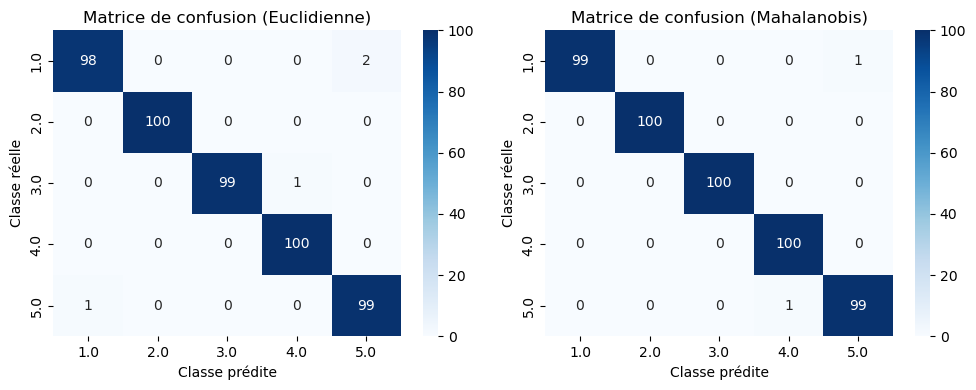

[1 2 3 4 5]
[1 2 3 4 5]
[1 2 3 4 5]


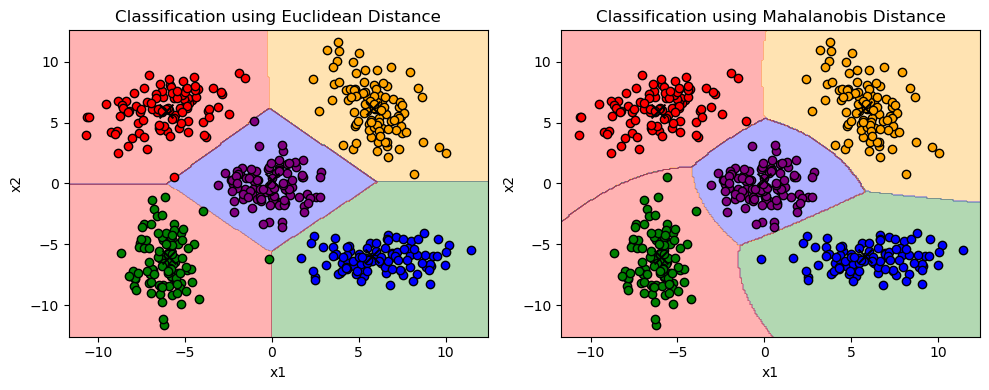

In [7]:
PredictResults(train_data1, test_data1)
# PredictResults(train_data2, test_data2)
# PredictResults(train_data3, test_data3)

## Kppv

##### Classification

In [8]:
def checkList(lst):
    ele = lst[0]
    chk = True

    # Comparing each element with first item
    for item in lst:
        if ele != item:
            chk = False
            break

    return chk

def predict_kppv(X_train, X_test, y_train, k, mod="majorité"):
    final_output = []
    for i in range(len(X_test)):
        d = []
        votes = []
        for j in range(len(X_train)):
            dist = euclidean_distance(X_train[j] , X_test[i])
            d.append([dist, j])
        d.sort()
        d = d[0:k]
        for d, j in d:
            votes.append(y_train[j])
        if mod == "unanimité" and checkList(votes)==False:
            ans = 6
        else:
            ans = Counter(votes).most_common(1)[0][0]
        final_output.append(ans)

    return final_output

def calculate_accuracy_kppv(prediction, y_test):
    return (prediction == y_test).sum()* 100 / len(y_test)


##### Plotting

In [9]:
def plot_confusion_matrices(confusion_mtx1, confusion_mtx2, confusion_mtx3, title1, title2, title3, unique_classes):
    # Criar a figura com 3 subgráficos: dois na linha superior e um na inferior
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaço entre os gráficos

    # Plot da primeira matriz de confusão
    sns.heatmap(confusion_mtx1, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=unique_classes, yticklabels=unique_classes)
    ax1.set_title(title1)
    ax1.set_xlabel('Classe Predita')
    ax1.set_ylabel('Classe Real')

    # Plot da segunda matriz de confusão
    sns.heatmap(confusion_mtx2, annot=True, fmt='d', cmap='Blues', ax=ax2, xticklabels=unique_classes, yticklabels=unique_classes)
    ax2.set_title(title2)
    ax2.set_xlabel('Classe Predita')
    ax2.set_ylabel('Classe Real')

    # Plot da terceira matriz de confusão
    unique_classes = np.append(unique_classes,6)
    sns.heatmap(confusion_mtx3, annot=True, fmt='d', cmap='Blues', ax=ax3, xticklabels=unique_classes, yticklabels=unique_classes)
    ax3.set_title(title3)
    ax3.set_xlabel('Classe Predita')
    ax3.set_ylabel('Classe Real')

    # Mostrar os gráficos
    plt.tight_layout()
    plt.show()


def plot_kppv_side_by_side(X_test, unique_classes, prediction1, prediction5, predictionUna):
    
    # Definir as cores dos pontos
    point_colors = ['red', 'orange', 'blue', 'green', 'purple', 'gray']

    # Criar a figura com 3 subgráficos: dois na linha superior e um na inferior
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar o espaço entre os gráficos
    
    # Gráfico 1: Classificação usando Kppv (1ppv)
    for i in unique_classes:
        ax1.scatter(X_test[prediction1 == i, 0], X_test[prediction1 == i, 1], c=point_colors[int(i) - 1])
    ax1.set_title("Classification using Kppv (1ppv)")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2")
    
    # Gráfico 2: Classificação usando Kppv (5ppv)
    for i in unique_classes:
        ax2.scatter(X_test[prediction5 == i, 0], X_test[prediction5 == i, 1], c=point_colors[int(i) - 1])
    ax2.set_title("Classification using Kppv (5ppv Majorité)")
    ax2.set_xlabel("x1")
    ax2.set_ylabel("x2")
    
    # Gráfico 3: Classificação usando Kppv (3ppv)
    unique_classes = np.append(unique_classes,6)
    for i in unique_classes:
        ax3.scatter(X_test[predictionUna == i, 0], X_test[predictionUna == i, 1], c=point_colors[int(i) - 1])
    ax3.set_title("Classification using Kppv (5ppv Unanimité)")
    ax3.set_xlabel("x1")
    ax3.set_ylabel("x2")
    
    # Mostrar os gráficos
    plt.tight_layout()
    plt.show()


##### Prediction Results

In [10]:
def PredictResults_Kppv(X_train, y_train, X_test, y_test):

    unique_classes = np.unique(y_train)

    # Prédire les classes avec les deux méthodes
    prediction1 = predict_kppv(X_train, X_test, y_train, k=1)
    prediction5 = predict_kppv(X_train, X_test, y_train, k=5)
    predictionUna = predict_kppv(X_train, X_test, y_train, k=5, mod="unanimité")

    # Étiquettes réelles (colonne 0 de test_data)
    actual_labels = y_train

    # Calculer la précision pour chaque méthode
    accuaracy1 = calculate_accuracy_kppv(prediction1, y_test)
    accuaracy5 = calculate_accuracy_kppv(prediction5, y_test)
    accuaracyUna = calculate_accuracy_kppv(predictionUna, y_test)

    # Générer les matrices de confusion
    confusion_matrix1 = Matrice_Confusion(actual_labels, prediction1)
    confusion_matrix5 = Matrice_Confusion(actual_labels, prediction5)
    confusion_matrixUna = Matrice_Confusion(actual_labels, predictionUna)

    # Afficher les résultats
    print(f"Précision classifieur 1ppv : {accuaracy1:.2f}%")
    print(f"Précision classifieur 5ppv Majorité : {accuaracy5:.2f}%")
    print(f"Précision classifieur 5ppv Unanimité : {accuaracyUna:.2f}%")

    # Afficher les matrices de confusion côte à côte
    plot_confusion_matrices(confusion_matrix1, confusion_matrix5, confusion_matrixUna,
                            "Matrice de confusion (1ppv)", "Matrice de confusion (5ppv Majorité)", "Matrice de confusion (5ppv Unanimité)", unique_classes)

    # Plot classification results side by side
    plot_kppv_side_by_side(X_test, unique_classes, prediction1, prediction5, predictionUna)

Précision classifieur 1ppv : 99.20%
Précision classifieur 5ppv Majorité : 99.60%
Précision classifieur 5ppv Unanimité : 98.40%


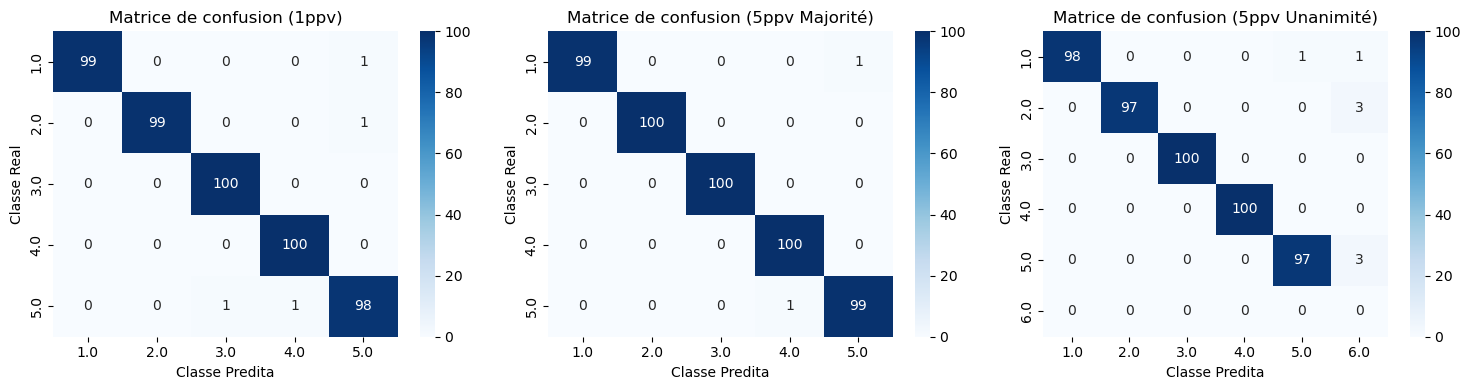

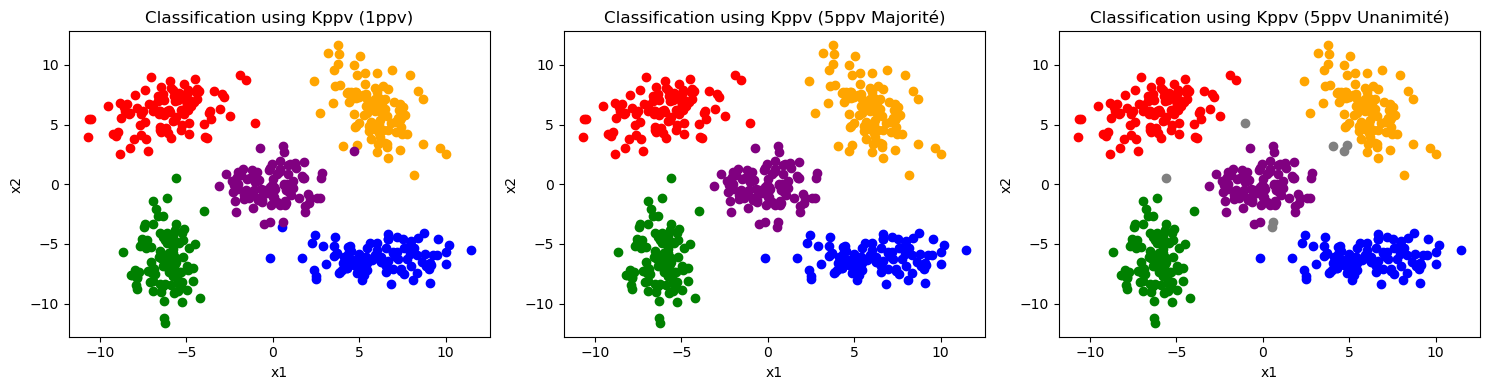

In [11]:
PredictResults_Kppv(X_train1, y_train1, X_test1, y_test1)
# PredictResults_Kppv(X_train2, y_train2, X_test2, y_test2)
# PredictResults_Kppv(X_train3, y_train3, X_test3, y_test3)

## Parzen